In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

import itertools
import waterfall_chart

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.externals.six import StringIO

from IPython.display import Image  
import pydotplus

## Przegląd danych

In [3]:
seed = 20

df = pd.read_stata('../data/HCMST 2017 fresh sample for public sharing draft v1.1.dta')
df.head()

,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0
3,6,2648857,Qualified,1.2597,98682.0,1.3507,1.2524,98110.0,0.418556,29052.0,...,no,no,no,no,White,no,16.0,12.0,12.0,12.0
4,7,2623465,Qualified,0.8686,68044.0,NaN,0.8636,67652.0,0.976522,67781.0,...,no,no,yes,no,White,no,14.0,17.0,16.0,16.0


### Wybrane zmienne

* Numeryczne
    * age_when_met 
    * time_from_met_to_rel
<br><br>
* Kategoryczne
    * ppagecat
    * ppincimp

In [4]:
num_feature1 = 'age_when_met'  # age when met in years,
num_feature2 = 'time_from_met_to_rel'  # Time from meeting to relationship
cat_feature1 = 'ppagecat'  # Age - 7 Categories
cat_feature2 = 'ppincimp'  # Household Income 
label = 'S1'  # Are you married?

#### Zakodowanie danych kategorycznych

In [5]:
def encode_cat(column):
    le = LabelEncoder()
    encoded_col = le.fit_transform(column)
    return le, encoded_col

In [6]:
df = df[[num_feature1, num_feature2, cat_feature1, cat_feature2, label]]
df = df.dropna()

le1, encoded_cat1 = encode_cat(df[cat_feature1])
le2, encoded_cat2 = encode_cat(df[cat_feature2])
df[cat_feature1] = encoded_cat1
df[cat_feature2] = encoded_cat2
df[label] = df[label].apply(lambda x: 1 if x == 'Yes, I am Married' else 0)
df.head()

,age_when_met,time_from_met_to_rel,ppagecat,ppincimp,S1
0,30.0,0.000000,1,13,0
1,21.0,12.250000,4,5,1
2,36.0,0.416748,3,8,1
3,23.0,1.083252,1,13,0
4,25.0,0.083252,4,6,1


#### Podział na zbiory - treningowy i testowy

In [7]:
X = df.drop(label, axis=1)
y = df[label]
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=seed)

## Trening i walidacja modelu

In [8]:
model = xgb.sklearn.XGBClassifier(learning_rate=0.1, n_estimators=100, reg_lambda=1.5, random_state=seed)
model.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=20, reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [9]:
pred_y = model.predict(test_X)
score = accuracy_score(pred_y, test_y)
print(f'Accuracy: {(score*100):.2f}%')

Accuracy: 77.70%


## LIME
#### Wybrany sample w okolicy, którego będzie użyty LIME

In [10]:
sample = train_X.loc[[880]]
lab = train_y.loc[880]
print(f'Married: {lab}')
sample

Married: 0


,age_when_met,time_from_met_to_rel,ppagecat,ppincimp
880,44.0,3.25,5,16


In [11]:
print(f'{cat_feature1}={sample[cat_feature1].item()}: {le1.classes_[sample[cat_feature1].item()]}')
print(f'{cat_feature2}={sample[cat_feature2].item()}: {le2.classes_[sample[cat_feature2].item()]}')

ppagecat=5: 65-74
ppincimp=16: $60,000 to $74,999


#### Generowanie punktów w sąsiedztwie

In [12]:
def generate_random_sample(sample, df, n):
    df = df.copy().iloc[:n]
    age_std = df['age_when_met'].std() / 5
    times_std = df['time_from_met_to_rel'].std() / 5
    new_ages = np.random.normal(loc=sample['age_when_met'], scale=age_std, size=(n,))
    new_times = np.maximum(np.random.normal(loc=sample['time_from_met_to_rel'], scale=times_std, size=(n,)), 0)
    df['age_when_met'] = new_ages
    df['time_from_met_to_rel'] = new_times
    
    ages_range = np.ptp(new_ages)
    times_range = np.ptp(new_times)
    
    weights = df[['age_when_met', 'time_from_met_to_rel']].values - sample[['age_when_met', 'time_from_met_to_rel']].values
    weights = weights / np.array(ages_range, times_range)
    weights = 1 / np.sqrt(np.sum(weights ** 2, axis=1))
    for col in ['ppagecat', 'ppincimp']:
        df[col] = sample[col].item()
    
    return df.reset_index(drop=True), weights

In [13]:
sample_df, sample_weights = generate_random_sample(sample, train_X, 1000)
sample_df.head()

,age_when_met,time_from_met_to_rel,ppagecat,ppincimp
0,44.392230,1.542652,5,16
1,44.070423,4.455710,5,16
2,37.689625,3.041455,5,16
3,43.631697,2.600070,5,16
4,42.939687,1.686174,5,16


#### Predykcje głównego modelu dla wygenerowanych punktów 

In [14]:
sample_preds = model.predict(sample_df)
jj = np.bincount(sample_preds)
ii = np.nonzero(jj)[0]
for p in zip(ii, jj[ii]) : print(p)

(0, 173)
(1, 827)


# Trening lokalnego drzewa decyzyjnego

In [15]:
local_model = DecisionTreeClassifier(max_depth=2)
local_model.fit(sample_df, sample_preds, sample_weight=sample_weights)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [16]:
pred_y = local_model.predict(test_X)
score = accuracy_score(pred_y, test_y)
print(f'Local model accuracy on entire test set: {(score*100):.2f}%')

Local model accuracy on entire test set: 67.16%


### Wykresy LIME
#### Funkcje do rysowania

In [17]:
def plot_lime(local_model, model, sample_df, sample, plot_step=0.1):
    x_min, x_max = sample_df['age_when_met'].min() - 1, sample_df['age_when_met'].max() + 1
    y_min, y_max = sample_df['time_from_met_to_rel'].min() - 1, sample_df['time_from_met_to_rel'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    fare = np.zeros(shape=())
    points = np.c_[xx.ravel(), yy.ravel()]

    img_df = pd.DataFrame(points, columns=['age_when_met', 'time_from_met_to_rel'])
    for col in ['ppagecat', 'ppincimp']:
        val = sample[col].item()
        img_df[col] = val


    local_Z = local_model.predict(img_df)
    local_Z = local_Z.reshape(xx.shape)
    Z = model.predict(img_df)
    Z = Z.reshape(xx.shape)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    plot_colors = ['red', 'blue']
    cs = axes[0].contourf(xx, yy, local_Z, cmap=plt.cm.RdYlBu)
    for i, color in zip(range(2), plot_colors):
        n_points = min(100, len(sample_df[sample_preds == i]))
        points = sample_df[sample_preds == i].sample(n=n_points)
        axes[0].scatter(points['age_when_met'], points['time_from_met_to_rel'], c=color, label=i,
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)
    axes[0].scatter(sample['age_when_met'], sample['time_from_met_to_rel'], c='yellow', marker='D', s=60)
    axes[0].set_title('LIME')
    axes[0].set_xlabel('age_when_met')
    axes[0].set_ylabel('time_from_met_to_rel')

    cs = axes[1].contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
    for i, color in zip(range(2), plot_colors):
        n_points = min(100, len(sample_df[sample_preds == i]))
        points = sample_df[sample_preds == i].sample(n=n_points)
        axes[1].scatter(points['age_when_met'], points['time_from_met_to_rel'], c=color, label=i,
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)
    axes[1].scatter(sample['age_when_met'], sample['time_from_met_to_rel'], c='yellow', marker='D', s=60)
    axes[1].set_title('Original model')
    axes[1].set_xlabel('age_when_met')
    axes[1].set_ylabel('time_from_met_to_rel')
    plt.show()
    
    
def plot_graph(model):
    dot_data = StringIO()
    export_graphviz(model, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

### Wykres klasyfikacji najbliższego otoczenia (po lewej model lokalny, po prawej oryginalny)

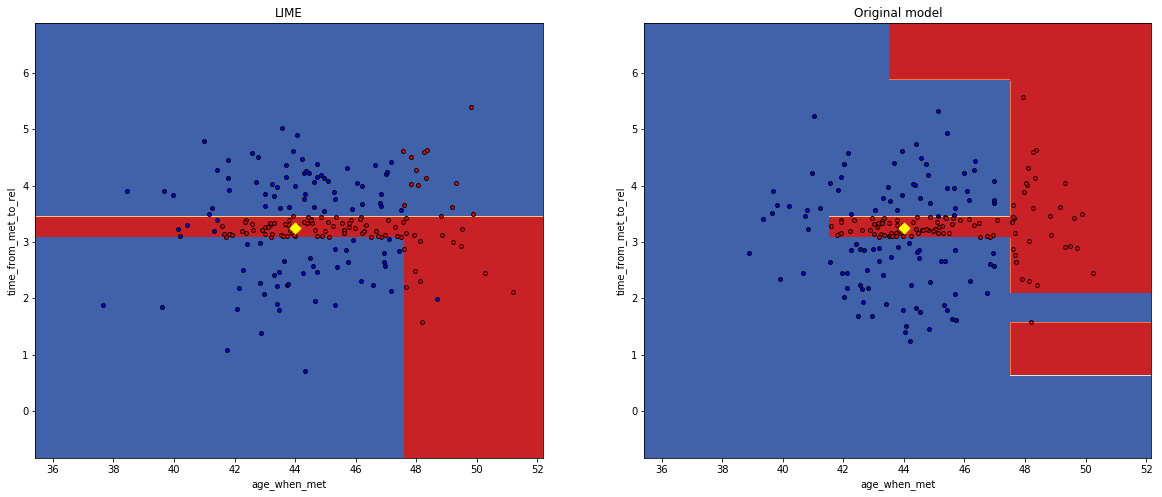

In [20]:
plot_lime(local_model, model, sample_df, sample, plot_step=0.01)

### Graf lokalnego drzewa decyzyjnego

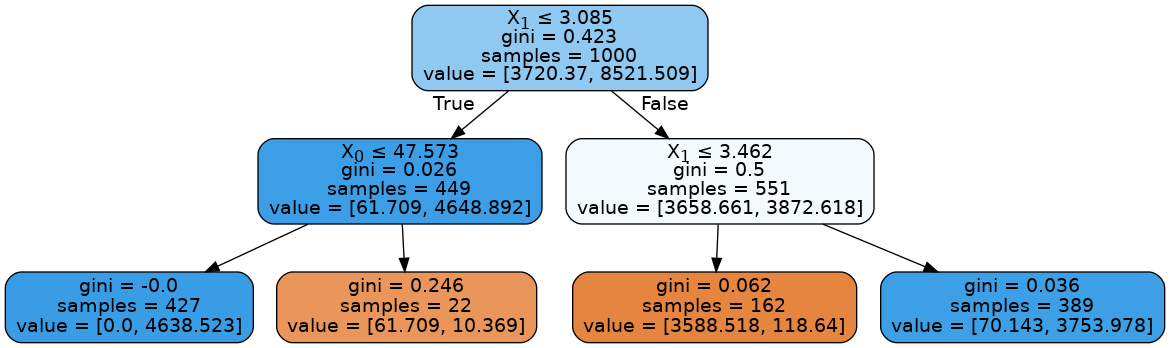

In [21]:
plot_graph(local_model)

## Wykresy (break down, shap)

#### Funkcje do tworzenia wykresów 

In [22]:
def break_down(model, df, sample, order):
    df = df.copy()
    preds = [np.mean(model.predict_proba(df)[:, 1])]
    for var in order:
        val = sample[var].item()
        df[var] = val
        pred = np.mean(model.predict_proba(df)[:, 1])
        preds.append(pred)
    return [preds[i] - preds[i-1] if i != 0 else preds[i] for i in range(len(preds))]


def plot_break_down(model, df, sample, order, cat_cols):
    changes = break_down(model, df, sample, order)
    labels = ['intercept'] + [f'{o}={sample[o].item():.02f}' if o not in cat_cols else f'{o}={sample[o].item()}' for o in order]
    plot = waterfall_chart.plot(labels, changes, net_label='total', formatting='{:,.3f}')
    plot.rcParams["figure.figsize"] = (12, 5)
    
    
def shap_values(model, df, sample, features):
    all_changes = {f: [] for f in features}
    for order in itertools.permutations(features):
        changes = break_down(model, df, sample, order)
        for f, change in zip(order, changes[1:]):
            all_changes[f].append(change)
    return {f: np.mean(changes) for f, changes in all_changes.items()}


def plot_shap(model, df, sample, features, cat_cols):
    shap_dict = shap_values(model, df, sample, features)
    plt.figure(figsize=(12,5))
    labels, shap_vals = list(shap_dict.keys()), list(shap_dict.values())
    labels = [f'{l}={sample[l].item():.02f}' if l not in cat_cols else f'{l}={sample[l].item()}' for l in labels]
    plt.bar(range(len(labels)), shap_vals)
    plt.xticks(range(len(labels)), labels)

#### Break down #1

In [23]:
order1 = [num_feature1, num_feature2, cat_feature1, cat_feature2]
order2 = order1[::-1]

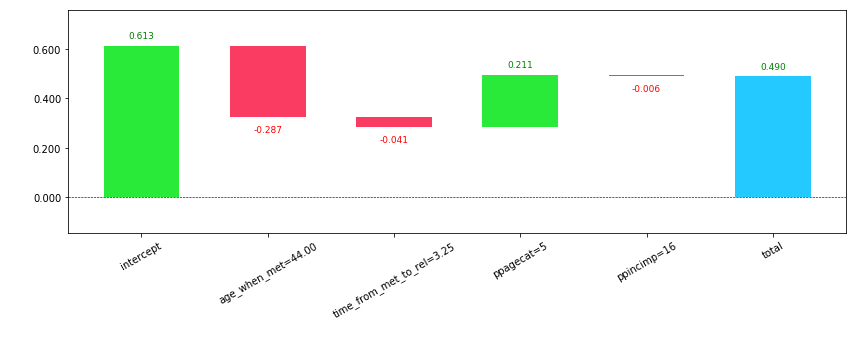

In [25]:
plot_break_down(model, train_X, sample, order1, cat_cols=[cat_feature1, cat_feature2])

#### Break down #2

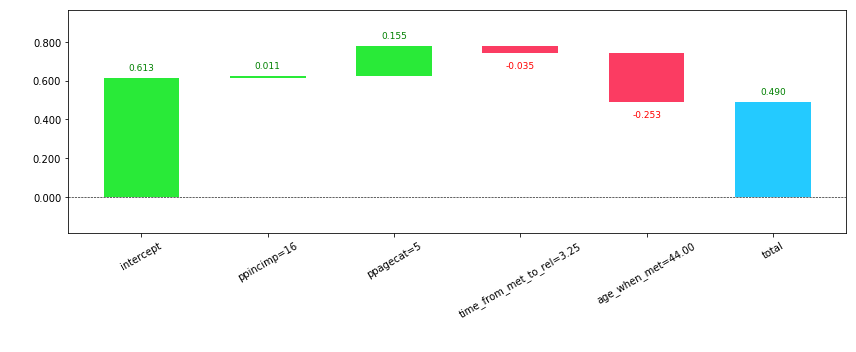

In [26]:
plot_break_down(model, train_X, sample, order2, cat_cols=[cat_feature1, cat_feature2])

#### SHAP

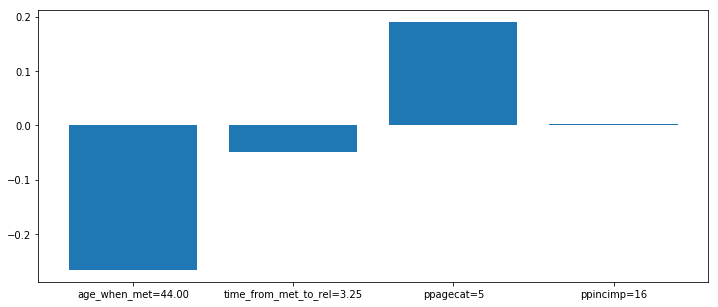

In [27]:
plot_shap(model, train_X, sample, order1, cat_cols=[cat_feature1, cat_feature2])

## Wnioski

Rozpatrywany przypadek:
* age_when_met = 44
* time_from_met_to_rel = 3.25
* ppagecat = 5: (65-74)
* ppincimp = 16: (\\$60,000 - \\$74,999)

Lokalne przybliżenie oryginalnego modelu (xgboost) drzewem decyzyjnym o głębokości 2 (przy ustalonych zmiennych kategorycznych) pozwala twierdzić, że oryginalny model dla ludzi z podobnym wiekiem spotkania (+/- 5 lat) i dla których czas od poznania do związku wynosi 3-3.5 lat przewiduje małe szanse na bycie w związku małżeńskim. Poza podanymm przedziałem drugiej z tych zmiennych szanse się odwracają. Pokrywa się to z wartością shap dla tej zmiennej, która pokazuje, że taka wartość średnio negatywnie wpływa na szansę małżeństwa. Dla zmiennej age_when_met wartość shap pokazuje, że średnio znacząco obniża szansę małżeństwa, natomiast w okolicy wybranego punktu lokalny model nie wskazuje na taką zależność. 